In [768]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder

In [769]:
df = pd.read_csv('helpdesk_customer_tickets.csv')
df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
1287,7800352194842,Asistencia requerida para la impresora Epson E...,"Estimado equipo de soporte al cliente,\r\n\r\n...","Estimado <name>,\r\n\r\nGracias por ponerte en...",Incident,Product Support,medium,es,Tech Online Store,Technical Support,Product Support,Hardware Failure,Problem Resolution,Service Recovery,Customer Service,NaN,NaN,NaN
881,4930657979228,Überprüfung der AWS-Rechnungsdifferenz,"Sehr geehrter Kundensupport,\r\n\r\nich schrei...","Sehr geehrter <name>,\r\n\r\nvielen Dank, dass...",Incident,Billing and Payments,low,de,IT Services,Billing Issue,Account Assistance,Customer Service,Refund Request,Payment Processing,NaN,NaN,NaN,NaN
639,3624422639318,Solicitação de Troca da Canon PIXMA MG3620,"Caro Suporte ao Cliente da Loja Online Tech,\r...",Assunto: Re: Solicitação de Troca da Canon PIX...,Request,Returns and Exchanges,low,pt,Tech Online Store,Returns and Exchanges,Product Support,Order Issue,Customer Service,NaN,NaN,NaN,NaN,NaN


In [770]:
df.dropna(subset=['body', 'subject'], inplace=True)

In [771]:

le = LabelEncoder()
df['type_encoded'] = le.fit_transform(df['type'])
df['queue_encoded'] = le.fit_transform(df['queue'])

df.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,type_encoded,queue_encoded
553,3230782463811,Clarification des frais de service,"Cher service client, j'espère que ce message v...","Cher <name>,\r\n\r\nMerci de nous avoir contac...",Request,Billing and Payments,medium,fr,IT Services,Billing Issue,Customer Service,Payment Processing,Account Assistance,NaN,NaN,NaN,NaN,NaN,3,0
615,3503744127507,Avis de maintenance planifiée,"Cher Équipe de Support Client, J'espère que ce...","Cher <name>,\r\n\r\nMerci de nous avoir contac...",Incident,Service Outages and Maintenance,low,fr,IT Services,System Maintenance,Service Notification,Service Disruption,Technical Support,Urgent Issue,NaN,NaN,NaN,NaN,1,8
246,1896031784670,Problema Intermitente de Congelamento do Curso...,"Caro Suporte ao Cliente,<br><br>Espero que est...","Caro <name>,\r\n\r\nObrigado por entrar em con...",Incident,Product Support,low,pt,Tech Online Store,Technical Support,Product Support,Hardware Failure,Technical Guidance,Urgent Issue,Problem Resolution,NaN,NaN,NaN,1,5


In [772]:
X = df[['subject', 'body', 'type_encoded', 'queue_encoded']]
y = df['priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [773]:
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('subject_tfidf', text_transformer, 'subject'),
        ('body_tfidf', text_transformer, 'body')
    ],
    remainder='passthrough'
)

# Full pipeline with classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [774]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('subject_tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'subject'),
                                                 ('body_tfidf',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'body')])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [775]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.76      0.92      0.83       157
         low       0.87      0.50      0.63        40
      medium       0.79      0.69      0.74       116

    accuracy                           0.78       313
   macro avg       0.81      0.70      0.73       313
weighted avg       0.79      0.78      0.77       313



### **Visualizing frequency of keywords in "subject" and "body" of email**
Reason for doing so -
- Logistic Regression model gives low precision when using count vectorization
- Random Forest Classifier gives low precison after using TF-IDF vectorizer

Why TD-IDF?
- TD-IDF is a weighting system that assigns a weight to each word in a document 
- It shows how significant a word is. 
- In terms of the current problem statement, TD-IDF can allow me to find a relation between frequency of certain keywords and their priorities 

In [82]:
df_new = pd.read_csv('helpdesk_customer_tickets.csv')
df_new.dropna(subset=['body', 'subject'], inplace=True)
df_new = df_new[df_new.language == 'en']

# Get high priority emails 
high_priority_emails = df_new[df_new['priority'] == 'high']

# Combine subject and body for TF-IDF analysis
high_priority_texts = high_priority_emails['subject'] + ' ' + high_priority_emails['body']

tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
tdidf_matrix = tdidf_vectorizer.fit_transform(high_priority_texts)


In [83]:
from deep_translator import GoogleTranslator

translator = GoogleTranslator(source='auto', target='en')

df_multi_language = pd.read_csv('helpdesk_customer_tickets.csv')
df_multi_language.dropna(subset=['body', 'subject'], inplace=True)

# Translate all non-english emails
df_multi_language['subject_translated'] = df_multi_language['subject'].apply(lambda x: translator.translate(x))

In [84]:
df_multi_language.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,subject_translated
646,3651850857819,Solicitação Urgente para Modificação de Bilhet...,"Caro Suporte ao Cliente,\n\nEspero que esta me...","Caro <name>,\n\nObrigado por entrar em contato...",Change,Technical Support,high,pt,Software Development Company,Technical Support,Urgent Issue,Product Support,General Inquiry,Problem Resolution,Feature Request,NaN,NaN,NaN,Urgent Request for Jira Ticket Modification
9,1033012757171,Anmeldeprobleme mit Microsoft Surface Pro 7,"Sehr geehrter Tech Online Store Support,\n\nIc...","Sehr geehrter <name>,\n\nVielen Dank, dass Sie...",Problem,Technical Support,high,de,Tech Online Store,Login Issue,Technical Support,Product Support,Warranty Claim,Technical Guidance,Problem Resolution,NaN,NaN,NaN,Login issues with Microsoft Surface Pro 7
940,5313159633878,Sofortige Lösung erforderlich wegen Serveraus...,"Sehr geehrtes IT-Support-Team,\n\nUnser Kunde,...","Sehr geehrter <name>,\n\nVielen Dank, dass Sie...",Problem,Customer Service,high,de,IT Services,IT Support,Service Outage,Urgent Issue,Problem Resolution,Technical Support,NaN,NaN,NaN,NaN,Immediate solution required due to server failure


In [85]:
# store the translated emails
df_multi_language.to_csv('helpdesk_customer_tickets_translated.csv', index=False)

In [ ]:
df_multi_language['body_translated'] = df_multi_language['body'].apply(lambda x: translator.translate(x))

In [77]:
# remove subject column and bring subject_translated to the front
df_multi_language = df_multi_language[['subject_translated', 'body', 'type', 'queue', 'priority', 'language']]
df_multi_language.rename(columns={'subject_translated': 'subject'}, inplace=True)
df_multi_language.sample(3) 

,subject,body,type,queue,priority,language
981,Urgent: Major AWS Outage,Estimado equipo de soporte al cliente de IT Se...,Incident,Service Outages and Maintenance,high,es
2,Urgent: Support needed for data recovery of My...,"Hallo, wir haben severe Datenverluste in MySQL...",Incident,Technical Support,high,de
730,Urgent: AWS deployment issue,El cliente no puede acceder a la consola de AW...,Incident,Customer Service,medium,es


,subject,body,type,queue,priority,language
347,Software Update Request,"Dear Support Team, I am writing to request an ...",Change,Product Support,high,en
987,Assistance Needed: Jira Software 8.20 Setup,"Caro Suporte ao Cliente da Tech Online Store,\...",Request,Product Support,medium,pt
539,Screen Flickering Problem,Cher support technique de la boutique en ligne...,Problem,Product Support,medium,fr


In [777]:
# Extract words and their corresponding TF-IDF values

feature_names = tdidf_vectorizer.get_feature_names_out()
word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
print(top_words)


[('aws', 11.472954521220114), ('issue', 10.797263411300472), ('support', 8.958085994330709), ('urgent', 8.069937675703782), ('service', 7.899251247273243), ('team', 7.839500977601176), ('assistance', 7.489155821047256), ('immediate', 6.923712171026424), ('router', 6.899124039914563), ('management', 6.683362603017139)]


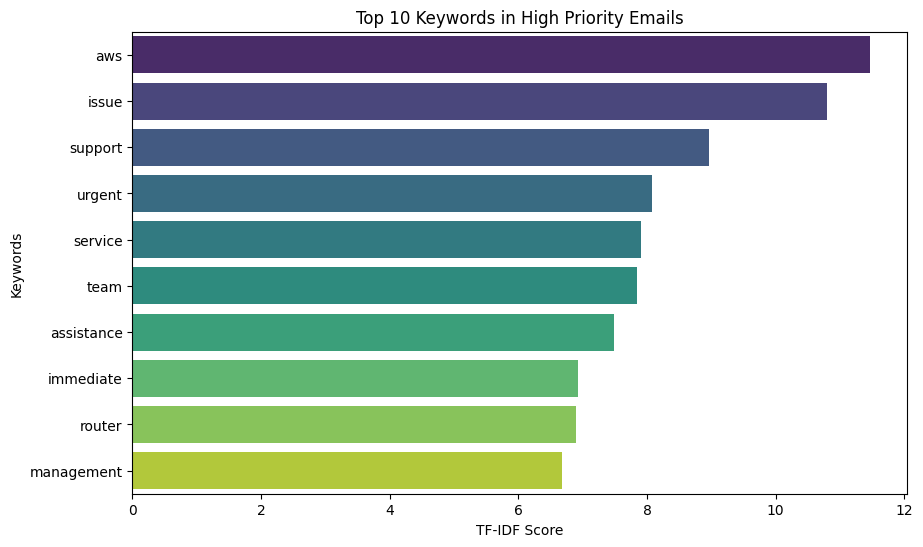

In [778]:
# Visualize the top 10 words with the highest TF-IDF scores
import matplotlib.pyplot as plt
import seaborn as sns

keywords, frequencies = zip(*top_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in High Priority Emails')
plt.show()

### Tokenizing and Lemmatizing keywords before performing same analysis again

In [779]:
import spacy

nlp = spacy.load('en_core_web_sm')

# create function to preprocess text
def preprocess_text(text):
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').strip().lower()
    doc = nlp(text)
    preprocessed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(preprocessed_tokens)

# preprocess the subject and body columns
df_new['subject_tokenized'] = df_new['subject'].apply(preprocess_text)
df_new['body_tokenized'] = df_new['body'].apply(preprocess_text)

In [780]:
df_new.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,subject_tokenized,body_tokenized
543,3180937326339,Critical: AWS Outage Situation,"Dear Customer Support Team for IT Services,\r\...","Dear <name>,\r\n\r\nWe appreciate your communi...",Incident,Technical Support,high,en,IT Services,Service Outage,Urgent Issue,Network Issue,IT Support,Incident Report,System Maintenance,Customer Service,NaN,NaN,critical aw outage situation,dear customer support team service < > wri...
623,3534727935440,High Priority Incident: Router Connectivity Is...,"Dear Customer Support,\r\n\r\nI hope this mess...","Dear <name>,\r\n\r\nThank you for reaching out...",Incident,Technical Support,high,en,IT Services,Urgent Issue,Network Issue,Technical Support,Service Disruption,Problem Resolution,Incident Report,Performance Tuning,NaN,NaN,high priority incident router connectivity issue,dear customer support hope message find wr...
1143,6782318492669,Urgent: Major AWS Outage,"Dear IT Services Customer Support Team, I am w...","Hello <name>,\r\n\r\nWe appreciate you contact...",Incident,Service Outages and Maintenance,high,en,IT Services,Service Outage,Urgent Issue,IT Support,Incident Report,Service Disruption,Problem Resolution,NaN,NaN,NaN,urgent major aw outage,dear service customer support team write bring...


In [781]:
high_priority_emails = df_new[df_new['priority'] == 'high']

high_priority_texts_preprocessed = high_priority_emails['subject_tokenized'] + ' ' + high_priority_emails['body_tokenized']

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
matrix = vectorizer.fit_transform(high_priority_texts_preprocessed)



In [782]:

feature_names = vectorizer.get_feature_names_out()
word_scores = zip(feature_names, matrix.sum(axis=0).tolist()[0])
top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
top_words

print(top_words)

[('issue', 14.166004981982207), ('service', 11.254135971675485), ('support', 9.453745904572987), ('urgent', 8.484549911777705), ('team', 8.323394282650256), ('assistance', 7.901045624278291), ('immediate', 7.305969855189135), ('router', 7.29556844885287), ('management', 7.060284135877624), ('server', 6.832658962091152)]


### Data Visualization - After tokeniziation and lemmatization

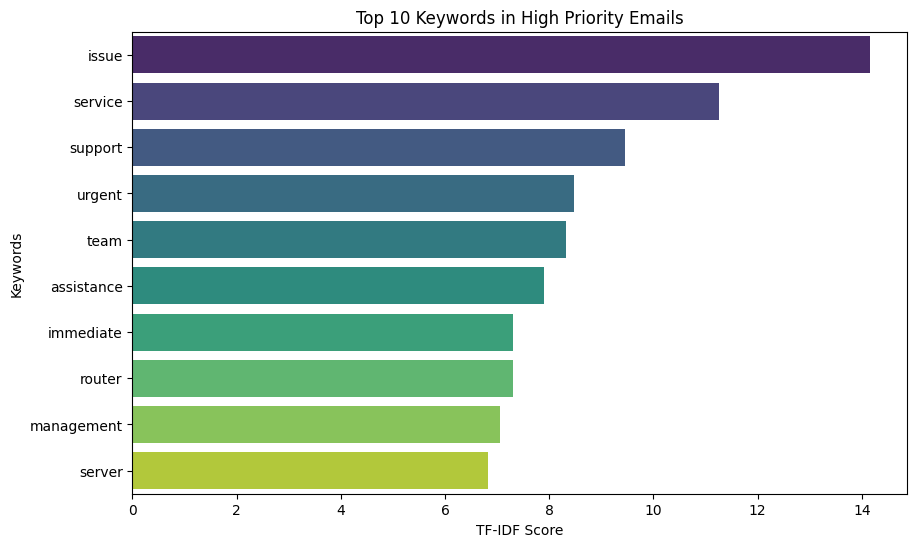

In [783]:
keywords, frequencies = zip(*top_words)

plt.figure(figsize=(10, 6))
sns.barplot(x=frequencies, y=keywords, palette='viridis', hue=keywords)
plt.xlabel('TF-IDF Score')
plt.ylabel('Keywords')
plt.title('Top 10 Keywords in High Priority Emails')
plt.show()

### Data Preprocessing 
- Creating one column for preprocessed text
- Label encoding for type and queue

In [784]:
df_new['preprocessed_text'] = df_new['subject_tokenized'] + ' ' + df_new['body_tokenized']

df_new.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,...,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,subject_tokenized,body_tokenized,preprocessed_text
322,2212627557731,Urgent Issue,"Hello Support Team, we are currently facing a ...","Hello <name>,\r\n\r\nThank you for reaching ou...",Incident,Technical Support,high,en,IT Consulting Firm,Urgent Issue,...,Service Disruption,Problem Resolution,System Maintenance,Software Bug,NaN,NaN,NaN,urgent issue,hello support team currently face major proble...,urgent issue hello support team currently face...
759,4239266926423,Critical Server Management Concern,"Dear Support Team of the IT Consulting Firm, a...","Dear <name>,\r\n\r\nWe appreciate your prompt ...",Incident,Technical Support,high,en,IT Consulting Firm,Technical Support,...,Service Disruption,Urgent Issue,Incident Report,Problem Resolution,Software Bug,System Maintenance,NaN,critical server management concern,dear support team consult firm problem emerge ...,critical server management concern dear suppor...
194,1686247592837,Assistance Needed for Printer Setup,"Dear Tech Online Store Support Team, \r\n\r\nI...","Dear <name>,\r\n\r\nThank you for reaching out...",Request,Customer Service,medium,en,Tech Online Store,Technical Support,...,IT Support,Problem Resolution,Service Recovery,NaN,NaN,NaN,NaN,assistance need printer setup,dear tech online store support team write...,assistance need printer setup dear tech online...


In [785]:
label_encoder_type = LabelEncoder()
label_encoder_queue = LabelEncoder()

df_new['type_encoded'] = label_encoder_type.fit_transform(df_new['type'])
df_new['queue_encoded'] = label_encoder_queue.fit_transform(df_new['queue'])

df_new.sample(3)

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,...,tag_5,tag_6,tag_7,tag_8,tag_9,subject_tokenized,body_tokenized,preprocessed_text,type_encoded,queue_encoded
1232,7362615969855,Billing Discrepancy with AWS Service,"Dear Customer Support,\r\n\r\nI am writing to ...",Subject: Billing Discrepancy - AWS Service\r\n...,Problem,Billing and Payments,high,en,Software Development Company,Billing Issue,...,Problem Resolution,Urgent Issue,NaN,NaN,NaN,billing discrepancy aw service,dear customer support write express concer...,billing discrepancy aw service dear customer s...,2,0
448,2741502249545,Battery Issue with Surface Pro,"Dear Tech Online Store Customer Support,\r\n\r...","Dear <name>,\r\n\r\nThank you for reaching out...",Incident,Product Support,medium,en,Tech Online Store,Technical Support,...,Problem Resolution,Service Recovery,NaN,NaN,NaN,battery issue surface pro,dear tech online store customer support ho...,battery issue surface pro dear tech online sto...,1,5
813,4501765832245,Assistance Required for MacBook Air Activation,"Hello Tech Online Store Support,\r\n\r\nI hope...","Hello,\r\n\r\nThank you for reaching out to Te...",Request,Product Support,high,en,Tech Online Store,Technical Support,...,Technical Guidance,Login Issue,NaN,NaN,NaN,assistance require macbook air activation,hello tech online store support hope messa...,assistance require macbook air activation hell...,3,5


In [786]:
# Clean unnecessary columns - answer, id, language, business_type
df_new.drop(columns=['answer', 'id', 'language', 'business_type'], inplace=True)

df_new.sample(3)

,subject,body,type,queue,priority,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,subject_tokenized,body_tokenized,preprocessed_text,type_encoded,queue_encoded
536,Request for Printer Exchange,"Dear Tech Online Store Support,\r\n\r\nI am ex...",Request,Returns and Exchanges,medium,Returns and Exchanges,Product Support,Warranty Claim,Technical Support,Order Issue,NaN,NaN,NaN,NaN,request printer exchange,dear tech online store support experience ...,request printer exchange dear tech online stor...,3,6
895,Assistance Needed for Epson EcoTank ET-4760 Pa...,"Dear Tech Online Store Support Team, I am expe...",Incident,Product Support,medium,Technical Support,Product Support,Problem Resolution,Hardware Failure,Service Recovery,NaN,NaN,NaN,NaN,assistance need epson ecotank et-4760 paper jam,dear tech online store support team experience...,assistance need epson ecotank et-4760 paper ja...,1,5
1343,Immediate Support Required: Cisco ISR4331 Rout...,"Dear Customer Support, \r\n\r\nI trust this m...",Incident,Technical Support,high,Technical Support,Network Issue,Service Outage,Urgent Issue,Problem Resolution,Hardware Failure,NaN,NaN,NaN,immediate support require cisco isr4331 router...,dear customer support trust message find...,immediate support require cisco isr4331 router...,1,9


In [787]:
# Remove other unnecessary columns and store in new df
df_cleaned = df_new[['preprocessed_text', 'type_encoded', 'queue_encoded', 'priority']]

df_cleaned.sample(3)

# Store the cleaned data in a new CSV file
df_cleaned.to_csv('preprocessed_tickets.csv', index=False)

**NOTE**: Above dataframe has insufficient data records (338) for training the model. Text augmentation can be used to synthesize more records 

In [788]:
# Split the data into training and testing sets

X = df_cleaned[['preprocessed_text', 'type_encoded', 'queue_encoded']]
y = df_cleaned['priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Using RandomForestClassifier 

In [789]:
# Building the TF-IDF transformer and model pipeline
text_transformer = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('text_tfidf', text_transformer, 'preprocessed_text')
    ],
    remainder='passthrough'  # Keep numerical columns: type_encoded, queue_encoded
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [790]:
# Train the model
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.76      0.80      0.78        40
         low       0.00      0.00      0.00         9
      medium       0.42      0.58      0.49        19

    accuracy                           0.63        68
   macro avg       0.39      0.46      0.42        68
weighted avg       0.57      0.63      0.60        68



c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [791]:
df_cleaned.sample(3)
X_train.shape
X_test.shape

(68, 3)

### Using Logistic Regression 

In [792]:
from sklearn.linear_model import LogisticRegression

text_transformer_2 = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('text_tfidf', text_transformer_2, 'preprocessed_text')
    ],
    remainder='passthrough'  # Keep numerical columns: type_encoded, queue_encoded
)

pipeline_2 = Pipeline([
    ('preprocessor', preprocessor_2),
    ('classifier', LogisticRegression(random_state=42))
])

# Train the model
pipeline_2.fit(X_train, y_train)

y_pred = pipeline_2.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        high       0.76      0.85      0.80        40
         low       0.00      0.00      0.00         9
      medium       0.52      0.63      0.57        19

    accuracy                           0.68        68
   macro avg       0.43      0.49      0.46        68
weighted avg       0.59      0.68      0.63        68



c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

### Using SVM

In [793]:
from sklearn.svm import SVC

text_transformer_3 = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preprocessor_3 = ColumnTransformer(
    transformers=[
        ('text_tfidf', text_transformer_3, 'preprocessed_text')
    ],
    remainder='passthrough'  # Keep numerical columns: type_encoded, queue_encoded
)

pipeline_3 = Pipeline([
    ('preprocessor', preprocessor_3),
    ('classifier', SVC(random_state=42))
])

# Train the model
pipeline_3.fit(X_train, y_train)

y_pred = pipeline_3.predict(X_test)

print(classification_report(y_test, y_pred))

c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        high       0.65      0.90      0.76        40
         low       0.00      0.00      0.00         9
      medium       0.38      0.26      0.31        19

    accuracy                           0.60        68
   macro avg       0.35      0.39      0.36        68
weighted avg       0.49      0.60      0.53        68



c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\kripa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Model precision low, analyzing data again ...

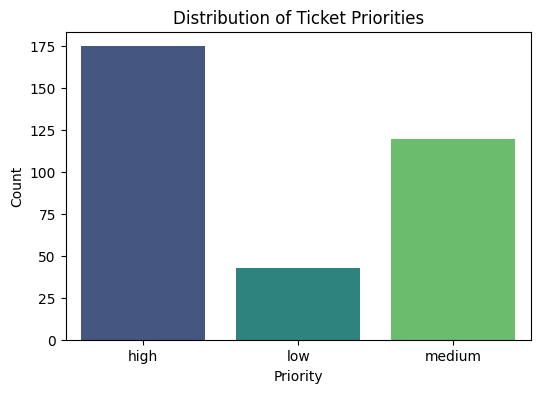

In [794]:
# count plot for high, medium and low priority tickets

plt.figure(figsize=(6, 4))
sns.countplot(x='priority', data=df_cleaned, palette='viridis', hue='priority')
plt.xlabel('Priority')
plt.ylabel('Count')
plt.title('Distribution of Ticket Priorities')

plt.show()

In [795]:
df.language.value_counts()

language
de    397
es    378
en    338
pt    229
fr    222
Name: count, dtype: int64

### Synthesizing new records 

In [803]:
df_new.sample(3)

# Add columns subject, body, type, queue, priority
df_clipped = df_new[['subject', 'body', 'type', 'queue', 'priority']]

df_clipped.sample(3)

,subject,body,type,queue,priority
1222,Critical Server Management Problem,"Dear Support Team at IT Consulting Firm, we ha...",Incident,Technical Support,high
825,Upgrade Zoom Request,"Dear Customer Support,\r\n\r\nI hope this emai...",Change,Technical Support,high
689,Critical Situation,"Hello Support Team, we are facing a significan...",Incident,Technical Support,high


In [804]:
import random
from nltk.corpus import wordnet
import spacy

# Load SpaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Function to preprocess text
def preprocess_text(text):
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Function for synonym replacement
def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    for _ in range(n):
        word_to_replace = random.choice(words)
        synonyms = wordnet.synsets(word_to_replace)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == word_to_replace else word for word in new_words]
    return " ".join(new_words)

# Function for random insertion
def random_insertion(text, n=1):
    words = text.split()
    for _ in range(n):
        random_word = random.choice(words)
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            insert_position = random.randint(0, len(words))
            words.insert(insert_position, synonym)
    return " ".join(words)

# Function for random deletion
def random_deletion(text, p=0.1):
    words = text.split()
    if len(words) == 1:
        return text
    new_words = [word for word in words if random.random() > p]
    return " ".join(new_words) if new_words else random.choice(words)

# Function for shuffling
def shuffle_words(text):
    words = text.split()
    random.shuffle(words)
    return " ".join(words)

# Apply text augmentation
augmented_data_map = {}

for index, row in df_clipped.iterrows():
    # original data
    augmented_data_map[index] = {
        'subject': row['subject'],
        'body': row['body'],
        'priority': row['priority'],
        'type': row['type'],
        'queue': row['queue']
    }
    
    # synonym replacement
    augmented_data_map[f'{index}_synonym'] = {
        'subject': synonym_replacement(row['subject']),
        'body': synonym_replacement(row['body']),
        'priority': row['priority'],
        'type': row['type'],
        'queue': row['queue']
    }
    
    # random insertion
    augmented_data_map[f'{index}_insertion'] = {
        'subject': random_insertion(row['subject']),
        'body': random_insertion(row['body']),
        'priority': row['priority'],
        'type': row['type'],
        'queue': row['queue']
    }
    
    # random deletion
    augmented_data_map[f'{index}_deletion'] = {
        'subject': random_deletion(row['subject']),
        'body': random_deletion(row['body']),
        'priority': row['priority'],
        'type': row['type'],
        'queue': row['queue']
    }
    
    # shuffling
    augmented_data_map[f'{index}_shuffle'] = {
        'subject': shuffle_words(row['subject']),
        'body': shuffle_words(row['body']),
        'priority': row['priority'],
        'type': row['type'],
        'queue': row['queue']
    }
    
# Create a new DataFrame with augmented data
augmented_data_df = pd.DataFrame(augmented_data_map).T
    
augmented_data_df.sample(3)


,subject,body,priority,type,queue
1026_synonym,pressing Support for Laptop Issue,"Dear Tech Online Store Support, I americium wr...",high,Request,Product Support
271_synonym,Urgent: ticket System Errors,"Dear IT Services Customer Support, I am writin...",high,Incident,Technical Support
480_shuffle,Dell XPS 13 overheating Issue with,resolving greatly you and workflow productivit...,medium,Incident,Sales and Pre-Sales


In [805]:
augmented_data_df.shape

(1690, 5)

In [806]:
# Combine the original and augmented data
df_combined = pd.concat([df_clipped, augmented_data_df], ignore_index=True)

df_combined.sample(3)

,subject,body,type,queue,priority
1161,Request to Return HP DeskJet 3755,Dear Customer I am experiencing wireless conne...,Request,Returns and Exchanges,medium
1435,Urgent: Cisco ISR4331 Issues,"Dear Customer Support, I am writing to bring t...",Incident,Technical Support,high
1817,Fix Downtime to Server Required Support Urgent,"restore Service, We prompt Services IT Consult...",Problem,Technical Support,high


In [807]:
# Store the combined data in a new CSV file

df_combined.to_csv('augmented_tickets.csv', index=False)

In [ ]:
# preprocess the subject and body columns
def preprocess_text(text):
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ').strip().lower()
    doc = nlp(text)
    preprocessed_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return ' '.join(preprocessed_tokens)